### 1. `np.interp`

**Function**: `np.interp(x, xp, fp)`

**Description**: This function performs one-dimensional linear interpolation. It finds the values of a function given discrete data points.

**Parameters**:
- `x`: The x-coordinates at which to evaluate the interpolated values.
- `xp`: The x-coordinates of the data points.
- `fp`: The y-coordinates of the data points.

**What it does**: `np.interp` takes an array of x-coordinates `x` and finds the corresponding y-values based on the linear interpolation of the given data points (`xp`, `fp`). In essence, it estimates y-values at new x-coordinates based on known x-y pairs.

**Usage in the Script**:
```python
skyline_intensities = np.interp(skyline_wavelengths, wavelength, spectrum)
```
Here, `np.interp` is used to find the intensity values of the spectrum at the specific skyline wavelengths. It interpolates the given spectrum data (with known wavelengths and intensities) to estimate the intensity at the skyline wavelengths.

### 2. `np.polyfit`

**Function**: `np.polyfit(x, y, deg)`

**Description**: This function fits a polynomial of a specified degree to the given data using the least squares method.

**Parameters**:
- `x`: The x-coordinates of the data points.
- `y`: The y-coordinates of the data points.
- `deg`: The degree of the polynomial to fit.

**What it does**: `np.polyfit` returns the coefficients of a polynomial of degree `deg` that best fits the data points (`x`, `y`). The fit minimizes the squared error between the data points and the polynomial.

**Usage in the Script**:
```python
fitted_intensities = np.polyval(np.polyfit(wavelength, spectrum, 1), skyline_wavelengths)
```
Here, `np.polyfit(wavelength, spectrum, 1)` computes the coefficients of a linear polynomial (degree 1) that fits the spectrum data. These coefficients are then used to evaluate the polynomial at the skyline wavelengths using `np.polyval`.

### 3. `np.polyval`

**Function**: `np.polyval(p, x)`

**Description**: This function evaluates a polynomial at specific values.

**Parameters**:
- `p`: The polynomial coefficients (from highest degree to the constant term).
- `x`: The x-coordinates at which to evaluate the polynomial.

**What it does**: `np.polyval` computes the value of the polynomial defined by coefficients `p` at the points `x`.

**Usage in the Script**:
    
fitted_intensities = np.polyval(np.polyfit(wavelength, spectrum, 1), skyline_wavelengths)

After obtaining the polynomial coefficients from `np.polyfit`, `np.polyval` uses these coefficients to evaluate the polynomial at the skyline wavelengths, resulting in `fitted_intensities`. This provides an estimated intensity at each skyline wavelength based on the linear fit of the entire spectrum.

### Summary

- **`np.interp`**: Interpolates the intensity values at the given skyline wavelengths based on the spectrum data.
- **`np.polyfit`**: Fits a linear polynomial to the spectrum data.
- **`np.polyval`**: Evaluates the fitted polynomial at the skyline wavelengths to get the fitted intensity values.

These functions together allow the script to estimate intensity values at specific wavelengths and analyze the residuals between these estimated values and the actual interpolated values.

If you have the code below that takes skylines and plots them as dash lines on the spectrum, but the spectrum's trough is not exactly on the dash lines like the example in the image, can you write a code that will adjust the specifically selected troughs by cliking on them throungh the image window and then asigned them to to their nearest selected dash lines through cliking? Then, you can save the new adjusted spectrum in fits format.

fits_file_path = 'spec_with_sky_00.fits'
skyline_file_path = 'new_wave_lamp/telluric_lines_test.dat'

# Open and read the FITS file
with fits.open(fits_file_path) as hdul:
    spectra_data = hdul[1].data[0]
    wavelength_data = hdul[4].data[0]

# Read the skyline file
skyline_wavelengths = np.loadtxt(skyline_file_path)
# Extract the first spectrum and wavelength for demonstration
spectrum = spectra_data
wavelength = wavelength_data
ax1.plot(wavelength, spectrum, label='Spectra')
#ax1.scatter(skyline_wavelengths, skyline_intensities, color='green', s=40, label='Skyline')
for wl in skyline_wavelengths:
    ax1.axvline(wl, color='red', linestyle='--', alpha=0.5)
ax1.set_ylabel('Intensity')
ax1.set_title('Spectra')
ax1.legend()

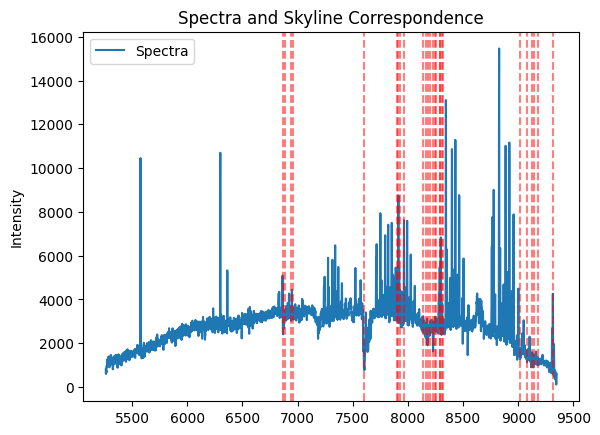

Adjusted spectrum saved to adjusted_spec_with_sky.fits


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backend_bases import MouseButton
from astropy.io import fits

# Load the FITS and skyline data
fits_file_path = 'spec_with_sky_00.fits'
skyline_file_path = 'new_wave_lamp/telluric_lines_test.dat'

with fits.open(fits_file_path) as hdul:
    spectra_data = hdul[1].data[0]
    wavelength_data = hdul[4].data[0]

skyline_wavelengths = np.loadtxt(skyline_file_path)

# Extract the first spectrum and wavelength for demonstration
spectrum = spectra_data
wavelength = wavelength_data

# Plotting
fig, ax1 = plt.subplots()

ax1.plot(wavelength, spectrum, label='Spectra')
for wl in skyline_wavelengths:
    ax1.axvline(wl, color='red', linestyle='--', alpha=0.5)
ax1.set_ylabel('Intensity')
ax1.set_title('Spectra and Skyline Correspondence')
ax1.legend()

# Variables to store clicked points
selected_troughs = []
assigned_skylines = []

# Click event handler
def on_click(event):
    if event.button is MouseButton.LEFT:
        # Identify the closest trough in the spectrum
        x_click = event.xdata
        closest_trough_idx = (np.abs(wavelength - x_click)).argmin()
        closest_trough = wavelength[closest_trough_idx]
        
        selected_troughs.append(closest_trough)
        ax1.axvline(closest_trough, color='blue', linestyle='-', alpha=0.7)
        fig.canvas.draw()
        
    elif event.button is MouseButton.RIGHT:
        if selected_troughs:
            x_click = event.xdata
            # Assign to nearest skyline
            closest_skyline = skyline_wavelengths[np.abs(skyline_wavelengths - x_click).argmin()]
            assigned_skylines.append(closest_skyline)
            
            # Adjust the spectrum trough to this skyline wavelength
            last_trough = selected_troughs.pop()
            trough_idx = np.where(wavelength == last_trough)[0][0]
            wavelength[trough_idx] = closest_skyline
            
            # Plot adjusted trough
            ax1.axvline(closest_skyline, color='green', linestyle='-', alpha=0.7)
            fig.canvas.draw()
            
def save_adjusted_spectrum():
    # Save the adjusted spectrum in a new FITS file
    new_fits_file_path = 'adjusted_spec_with_sky.fits'
    
    with fits.open(fits_file_path) as hdul:
        hdul[1].data[0] = spectrum
        hdul[4].data[0] = wavelength
        hdul.writeto(new_fits_file_path, overwrite=True)
    print(f"Adjusted spectrum saved to {new_fits_file_path}")

# Connect the click event to the handler
cid = fig.canvas.mpl_connect('button_press_event', on_click)

# Show the plot
plt.show()

# Save the adjusted spectrum
save_adjusted_spectrum()


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

# Enable interactive plotting with Qt backend
%matplotlib qt

# Define file paths
fits_file_path = 'spec_with_sky_00.fits'
skyline_file_path = 'new_wave_lamp/telluric_lines_test.dat'

# Open and read the FITS file
with fits.open(fits_file_path) as hdul:
    spectra_data = hdul[1].data[0]
    wavelength_data = hdul[4].data[0]

# Read the skyline file
skyline_wavelengths = np.loadtxt(skyline_file_path)

# Extract the first spectrum and wavelength for demonstration
spectrum = spectra_data
wavelength = wavelength_data

# Interpolate the spectrum to get intensity values at skyline wavelengths
skyline_intensities = np.interp(skyline_wavelengths, wavelength, spectrum)

# Assume a simple linear fit for residuals demonstration (can be replaced with actual fit if needed)
fitted_intensities = np.polyval(np.polyfit(wavelength, spectrum, 1), skyline_wavelengths)
residuals = skyline_intensities - fitted_intensities

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=False, figsize=(10, 8))

# Plot the spectra
ax1.plot(wavelength, spectrum, label='Spectra')
#ax1.scatter(skyline_wavelengths, skyline_intensities, color='green', s=40, label='Skyline')
for wl in skyline_wavelengths:
    ax1.axvline(wl, color='red', linestyle='--', alpha=0.5)
ax1.set_ylabel('Intensity')
ax1.set_title('Spectra')
ax1.legend()

# Plot the residuals
ax2.scatter(skyline_wavelengths, residuals, color='green', s=40, label='Residuals')
for i, txt in enumerate(range(len(skyline_wavelengths))):
    ax2.annotate(txt, (skyline_wavelengths[i], residuals[i]), fontsize=8)
ax2.set_xlabel('Wavelength')
ax2.set_ylabel('Residuals')
ax2.set_title('Skyline Residuals')
ax2.legend()

# Set the main title
plt.suptitle('Spectra and Skyline Correspondence')
plt.tight_layout(rect=[0, 0, 1, 0.96])
# Show the plot
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

# Load the FITS and skyline data
fits_file_path = 'spec_with_sky_00.fits'
skyline_file_path = 'new_wave_lamp/telluric_lines_test.dat'

with fits.open(fits_file_path) as hdul:
    spectra_data = hdul[1].data[0]
    wavelength_data = hdul[4].data[0]

skyline_wavelengths = np.loadtxt(skyline_file_path)

# Extract the first spectrum and wavelength for demonstration
spectrum = spectra_data
wavelength = wavelength_data

# Plotting
fig, ax1 = plt.subplots()

ax1.plot(wavelength, spectrum, label='Spectra')
for wl in skyline_wavelengths:
    ax1.axvline(wl, color='red', linestyle='--', alpha=0.5)
ax1.set_ylabel('Intensity')
ax1.set_title('Spectra and Skyline Correspondence')
ax1.legend()

# Variables to store clicked points
selected_troughs = []
assigned_skylines = []

# Click event handler
def on_click(event):
    x_click = event.xdata
    
    if event.key == 'l':
        # Identify the closest trough in the spectrum
        closest_trough_idx = (np.abs(wavelength - x_click)).argmin()
        closest_trough = wavelength[closest_trough_idx]
        
        selected_troughs.append(closest_trough)
        ax1.axvline(closest_trough, color='blue', linestyle='-', alpha=0.7)
        fig.canvas.draw()
        
    elif event.key == 'r':
        if selected_troughs:
            # Assign to nearest skyline
            closest_skyline = skyline_wavelengths[np.abs(skyline_wavelengths - x_click).argmin()]
            assigned_skylines.append(closest_skyline)
            
            # Adjust the spectrum trough to this skyline wavelength
            last_trough = selected_troughs.pop()
            trough_idx = np.where(wavelength == last_trough)[0][0]
            wavelength[trough_idx] = closest_skyline
            
            # Plot adjusted trough
            ax1.axvline(closest_skyline, color='green', linestyle='-', alpha=0.7)
            fig.canvas.draw()
            
def save_adjusted_spectrum():
    # Save the adjusted spectrum in a new FITS file
    new_fits_file_path = 'adjusted_spec_with_sky.fits'
    
    with fits.open(fits_file_path) as hdul:
        hdul[1].data[0] = spectrum
        hdul[4].data[0] = wavelength
        hdul.writeto(new_fits_file_path, overwrite=True)
    print(f"Adjusted spectrum saved to {new_fits_file_path}")

# Connect the key press event to the handler
fig.canvas.mpl_connect('key_press_event', on_click)

# Show the plot
plt.show()

# Save the adjusted spectrum
save_adjusted_spectrum()


Write a code that will take the resulting spectrum from on_click function  above and save that spectrum as a new spectrum.

In [3]:
wavelength = np.array([500, 510, 520, 530])
x_click = 512

In [7]:
diffs = np.abs(wavelength - x_click)  # diffs = np.abs([500, 510, 520, 530] - 512) = [12, 2, 8, 18]
closest_trough_idx = diffs.argmin()   # closest_trough_idx = 1 (since 2 is the smallest value in diffs)
closest_trough = wavelength[closest_trough_idx]  # closest_trough = 510
print(closest_trough_idx)
print(closest_trough)

1
510


Modify code code so that it take the resulting spectrum after adjustment save and plot it to compare it to the original spectrum.